In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)

2022-07-01 09:56:59.714530: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version: 2.5.3


In [2]:
devs = tf.config.list_physical_devices(); print('Available devices:', devs)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
    ) 

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-07-01 09:57:01.555253: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-01 09:57:01.603998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 09:57:01.604216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 750 Ti computeCapability: 5.0
coreClock: 1.0845GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 80.47GiB/s
2022-07-01 09:57:01.604237: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-01 09:57:01.608284: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-01 09:57:01.608325: I tensorflow/stream_executor/pl

In [3]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 5

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 73 files belonging to 2 classes.
Using 59 files for training.
Found 73 files belonging to 2 classes.
Using 14 files for validation.


2022-07-01 09:57:03.400321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 09:57:03.400781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 09:57:03.400968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 750 Ti computeCapability: 5.0
coreClock: 1.0845GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 80.47GiB/s
2022-07-01 09:57:03.401037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1)

In [4]:
class_names = train_dataset.class_names
print(class_names)

['0-shave', '1-beard']


2022-07-01 09:57:08.902823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-01 09:57:08.922097: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


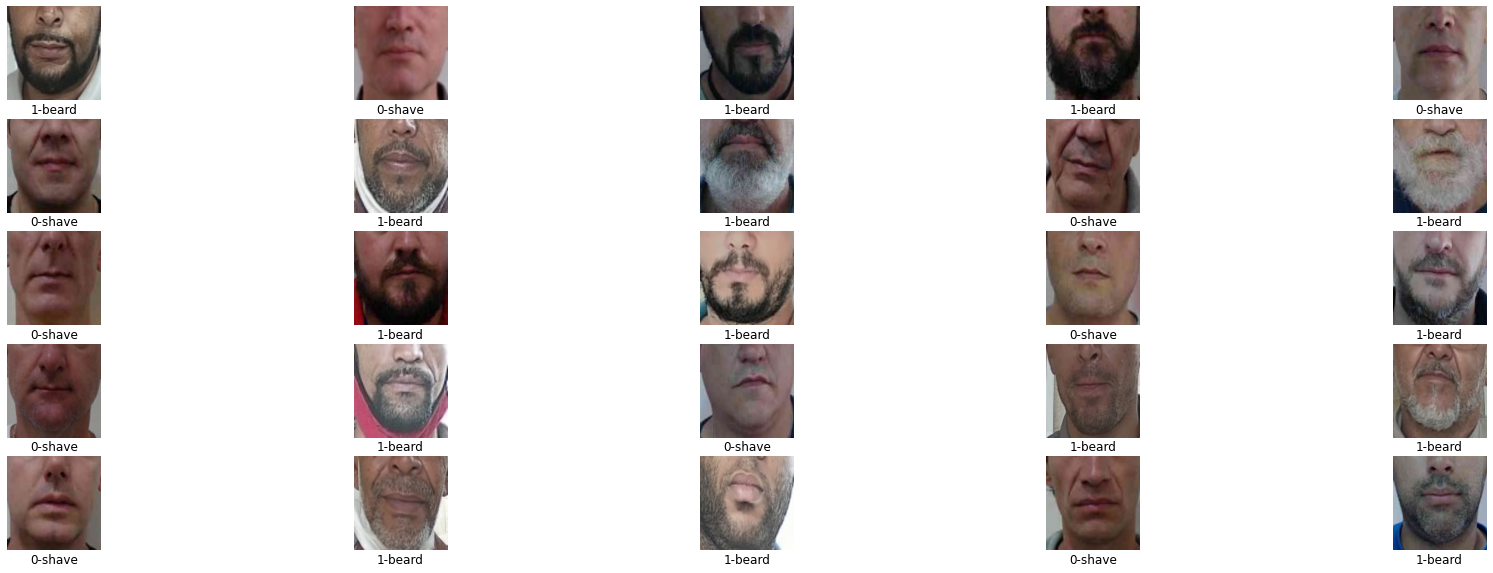

In [5]:
plt.figure(figsize=(30, 10))
for i, ( image, label ) in zip(range(25), train_dataset.unbatch()):    
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label], y=-0.20)
    plt.axis("off")
plt.show()

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 0


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.01)
        , tf.keras.layers.experimental.preprocessing.RandomZoom(
              height_factor=0.1
            , width_factor=0.1
        )
        , tf.keras.layers.experimental.preprocessing.RandomCrop(
              height=224
            , width=224
        )
        #, tf.keras.layers.experimental.preprocessing.RandomContrast(
        #    factor=0.1
        #)
    ]
)



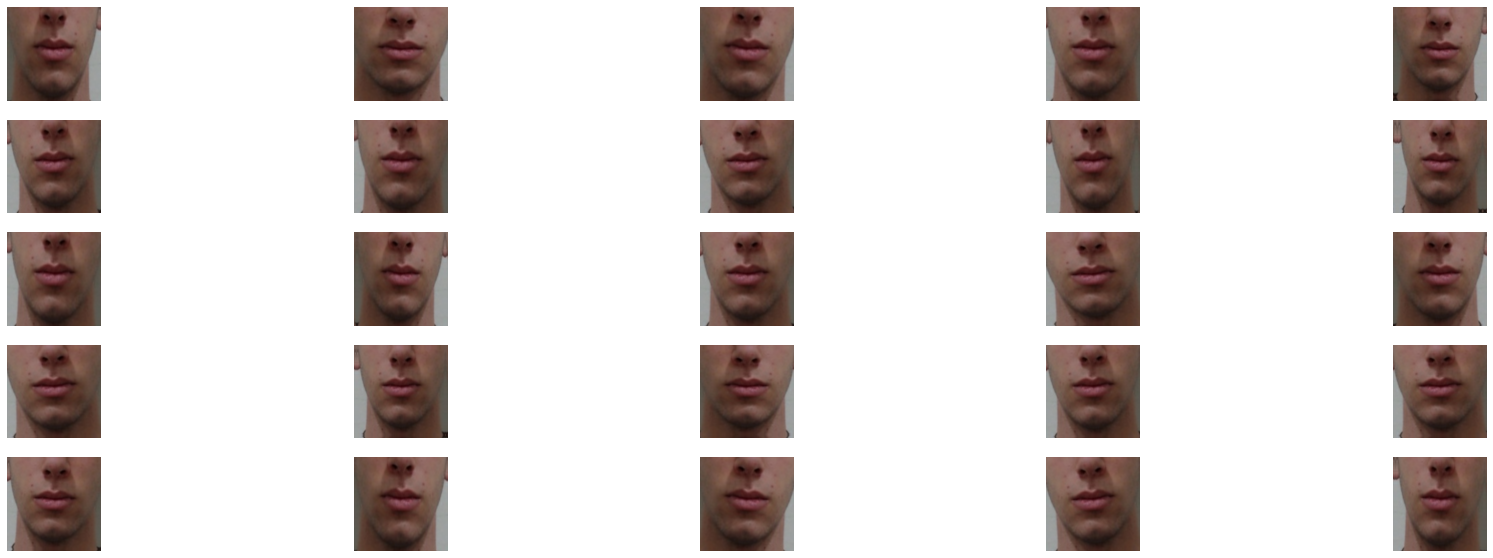

In [11]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
plt.show()

In [12]:
# MOBILENET_V3 
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [13]:
# Create the base model from the pre-trained model MobileNet V3
base_model = tf.keras.applications.MobileNetV3Small(
      input_shape=IMAGE_SHAPE
    , include_top=False
    , weights='imagenet'
    , alpha=0.75
)

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 7, 7, 1024)


In [14]:
base_model.trainable = False
# Prints the base model architecture
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [15]:
 # Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 1024)


In [16]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation=tf.nn.softmax)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 2)


In [17]:
IMAGE_SHAPE

(224, 224, 3)

In [18]:
# Build the model
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1026552   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 1,028,602
Trainable params: 2,050
Non-trainable params: 1,026,552
_______________________________________________

In [20]:
print(len(model.trainable_variables)) 

2


In [21]:
 # Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/3 [=========>....................] - ETA: 2s - loss: 0.6964 - accuracy: 0.8000

2022-07-01 09:58:59.134078: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 994.43MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


3/3 [==============================] - 2s 206ms/step - loss: 0.6959 - accuracy: 0.5714
initial loss: 0.70
initial accuracy: 0.57


2022-07-01 09:58:59.547081: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 993.48MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [23]:
initial_epochs = 15
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
12/12 [==============================] - 0s 25ms/step - loss: 0.5528 - accuracy: 0.7966 - val_loss: 0.5642 - val_accuracy: 0.7143
Epoch 2/15
12/12 [==============================] - 0s 23ms/step - loss: 0.5504 - accuracy: 0.7966 - val_loss: 0.5559 - val_accuracy: 0.7857
Epoch 3/15
12/12 [==============================] - 0s 27ms/step - loss: 0.5551 - accuracy: 0.7797 - val_loss: 0.5481 - val_accuracy: 0.7857
Epoch 4/15
12/12 [==============================] - 0s 22ms/step - loss: 0.5621 - accuracy: 0.7458 - val_loss: 0.5425 - val_accuracy: 0.8571
Epoch 5/15
12/12 [==============================] - 0s 25ms/step - loss: 0.5709 - accuracy: 0.6949 - val_loss: 0.5360 - val_accuracy: 0.8571
Epoch 6/15
12/12 [==============================] - 0s 27ms/step - loss: 0.5669 - accuracy: 0.7458 - val_loss: 0.5300 - val_accuracy: 0.8571
Epoch 7/15
12/12 [==============================] - 0s 24ms/step - loss: 0.5464 - accuracy: 0.8475 - val_loss: 0.5227 - val_accuracy: 0.8571
Epoch 8/15
12

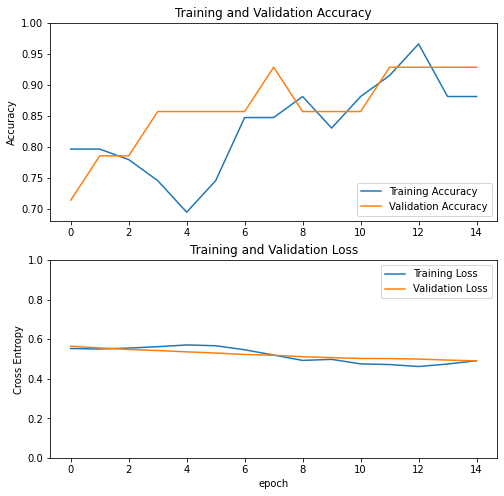

In [24]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Fine tuning
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
              metrics=['accuracy'])
model.summary()

In [ ]:
len(model.trainable_variables) 

In [ ]:
# Continue training the model
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_class[i]])
    plt.axis("off")

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

# SAVE
model.save('tensorflow_model/saved_modelv3small')
# model.save('saved_model/my_model.h5')
# model.save_weights('saved_model/checkpoint')

In [ ]:
#!source /opt/intel/openvino_2021/bin/setupvars.sh

In [ ]:
#!python3 /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py --saved_model_dir ./tensorflow_model/saved_modelv3small --output_dir ./openvino_model/saved_modelv3small --input_shape [1,224,224,3]